In [264]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
from tqdm import tqdm
from sklearn import preprocessing



In [266]:
df = pd.DataFrame()
lineage_dict = {}
bestlog_dict = {}
log_dict = {}

workdir = "../../SCER2/"
for log in tqdm(os.listdir(workdir)):
    path = os.path.join(workdir, log)
    if log.startswith('run') and os.path.isdir(path) :
        try: 
            lineage = pd.read_csv(workdir + log + '/lineage.tsv', sep='\t', comment='#')
            bestlog = pd.read_csv(workdir + log + '/bestlog.tsv', sep='\t', comment='#')
            progresslog = pd.read_csv(workdir + log + '/progress.log', sep='\t', comment='#')

            lineage_dict[log] = lineage.dropna()
            bestlog_dict[log] = bestlog
            log_dict[log] = progresslog
        except  FileNotFoundError:
            pass 


100%|██████████| 381/381 [07:17<00:00,  1.15s/it]


In [269]:
lineage_lens = ([len(lineage_dict[f'run{i}']) for i in range(1,201)])
bestlog_lens = ([len(bestlog_dict[f'run{i}']) for i in range(1,201)])
log_lens = ([len(log_dict[f'run{i}']) for i in range(1,201)])

all_lineage = pd.concat([lineage_dict[f'run{i}']for i in range(1,201)])
all_bestlog= pd.concat([bestlog_dict[f'run{i}']for i in range(1,201)])
all_log= pd.concat([log_dict[f'run{i}']for i in range(1,201)])

finals = pd.concat([lineage_dict[f'run{i}'].tail(1) for i in range(1,201)], axis=0)

print(f'len all_lineage {len(all_lineage)} \nlen all_bestlog {len(all_bestlog)} \nlen all_log {len(all_log)}')

len all_lineage 233945 
len all_bestlog 962561 
len all_log 96255940


# Correlations and distributions

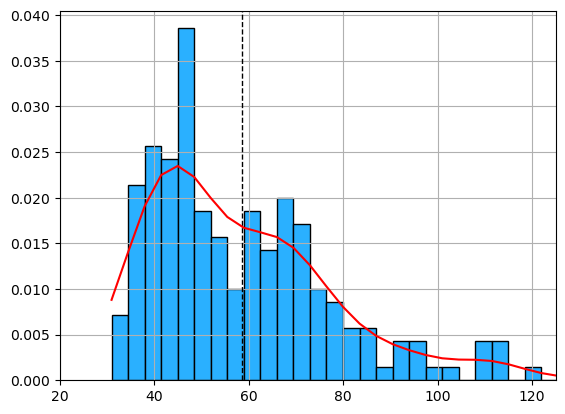

In [375]:
density = gaussian_kde(finals.seq_len)
plt.rcParams['axes.grid'] = True

n, x, _  =  plt.hist(finals.seq_len, bins=30, facecolor = '#2ab0ff', edgecolor='black', linewidth=1, density=True)
plt.xlim([20,125])
plt.axvline(finals.seq_len.mean(), color='k', linestyle='dashed', linewidth=1)

plt.plot(x, density(x), color='red')
plt.show()


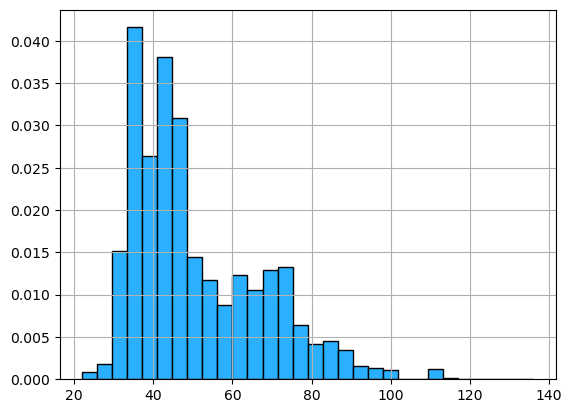

In [318]:
n, x, _  =  plt.hist(all_lineage.seq_len, bins=30, facecolor = '#2ab0ff', edgecolor='black', linewidth=1, density=True)
#plt.xlim([1,125])


In [250]:
#'*' : 0.4,   #partial duplication
#'/' : 0.3,   #random insertion 
#'%' : 0.9,   #partial deletion

df = all_log
b=35
e=45

part_dupl = df[df.mutation.str.contains('\*') & (df.seq_len > b) & (df.seq_len < e)].mutation.str.split('\*')
part_dupl_lens = [len(i[1]) for i in part_dupl]

random_insertion = df[df.mutation.str.contains('/')  & (df.seq_len > b) & (df.seq_len < e)].mutation.str.split('/')
random_insertion_lens = [len(i[1]) for i in random_insertion]

part_del = df[df.mutation.str.contains('%') & (df.seq_len > b) & (df.seq_len < e)].mutation.str.split('%')
part_del_len = [int(i[1]) for i in part_del]



In [323]:
part_dupl_lens = list(filter(lambda i: i > 1, part_dupl_lens))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


part_del  211564
part_dupl  106317
random_insertion  67479


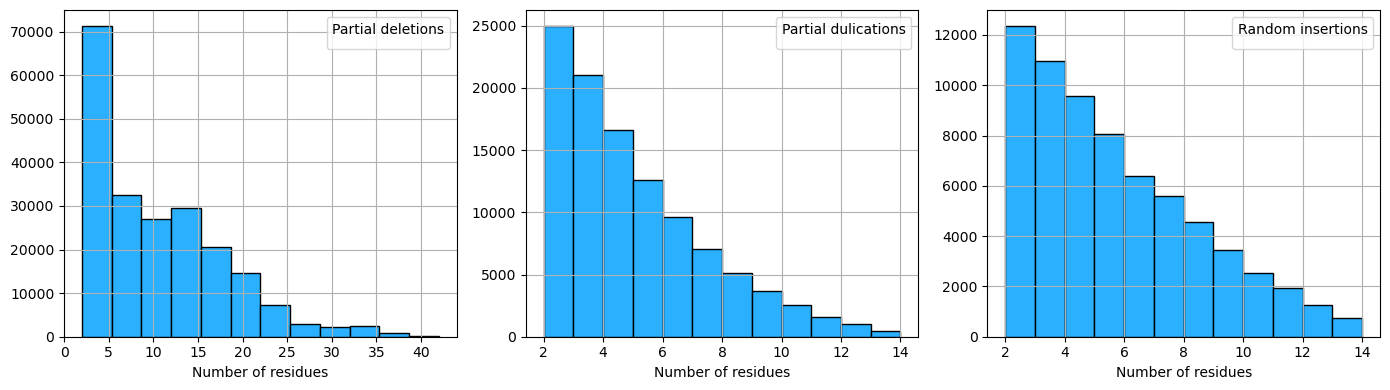

In [324]:
plt.style.use('default')
plt.rcParams['axes.grid'] = True

# histogram on linear scale
fig, ax = plt.subplots(1, 3, figsize=(14, 4), dpi=100)
nbins = 12


hist, bins, _ = ax[0].hist(part_del_len, bins=nbins, facecolor = '#2ab0ff', edgecolor='black', linewidth=1)
ax[0].set_xlabel("Number of residues")
ax[0].legend(title="Partial deletions")
#ax[0].set_xlim(0,100)

hist, bins, _ = ax[1].hist(part_dupl_lens, bins=nbins,  facecolor = '#2ab0ff', edgecolor='black', linewidth=1)
ax[1].set_xlabel("Number of residues")
ax[1].legend(title="Partial dulications")
#ax[1].set_xlim(0,50)

hist, bins, _ = ax[2].hist(random_insertion_lens, bins=nbins,  facecolor = '#2ab0ff', edgecolor='black', linewidth=1)
ax[2].set_xlabel("Number of residues")
ax[2].legend(title="Random insertions")
#ax[2].set_xlim(0,50)


fig.tight_layout()

print("part_del ", len(part_del_len))
print("part_dupl ", len(part_dupl_lens))
print("random_insertion ", len(random_insertion_lens))


In [243]:
print(min(part_del_len), min(part_dupl_lens), min(random_insertion_lens))



2 2 2


In [ ]:
correl_dict = {}
for pfe in bestlog_dict.keys():
    df = lineage_dict[pfe]
    df = df[df.ptm < 1]
    if len(df) > 3:
        x = df.score
        y = df.ptm
        correl_dict[pfe] = pearsonr(x, y)[0]
print("mean correlation between rosetta and pfes score is", np.array(list(correl_dict.values())).mean())


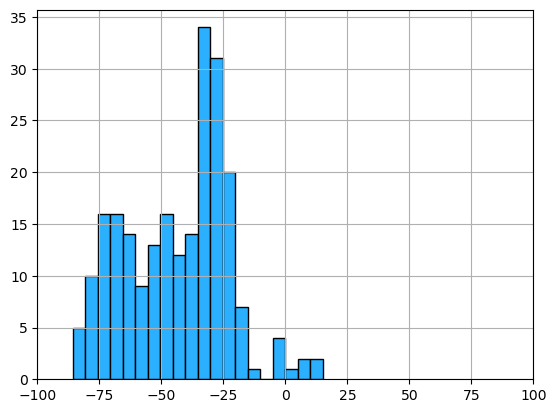

In [24]:
plt.style.use('default')

# histogram on linear scale
hist, bins, _ = plt.hist(lineage.NA, bins=20,  facecolor = '#2ab0ff', edgecolor='black', linewidth=1)
plt.xlim(-100,100)
plt.grid(True, which="both")



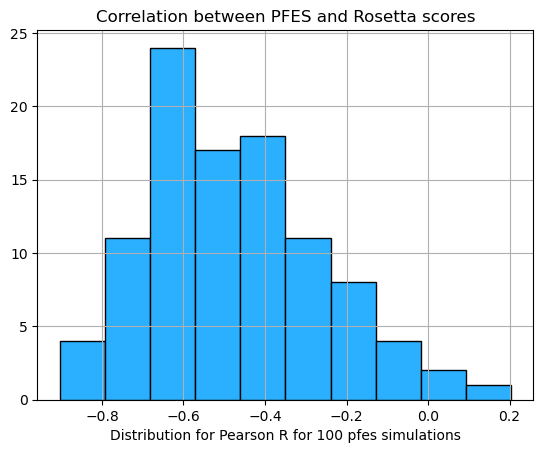

In [25]:
plt.style.use('default')
hist, bins, _ = plt.hist(correl_dict.values(), bins=10,  facecolor = '#2ab0ff', edgecolor='black', linewidth=1)
plt.title('Correlation between PFES and Rosetta scores')
plt.xlabel('Distribution for Pearson R for 100 pfes simulations')
plt.grid(True, which="both")



In [26]:
correl_df = pd.DataFrame({'name':list(correl_dict.keys()), 'correl':list(correl_dict.values())})
correl_df.sort_values('correl')

,name,correl
99,pfe50_99,-0.902763
97,pfe50_97,-0.835541
11,pfe50_19,-0.828937
49,pfe50_53,-0.825281
35,pfe50_40,-0.788182
...,...,...
55,pfe50_59,-0.068914
33,pfe50_39,-0.044950
5,pfe50_13,0.018451
20,pfe50_27,0.028031


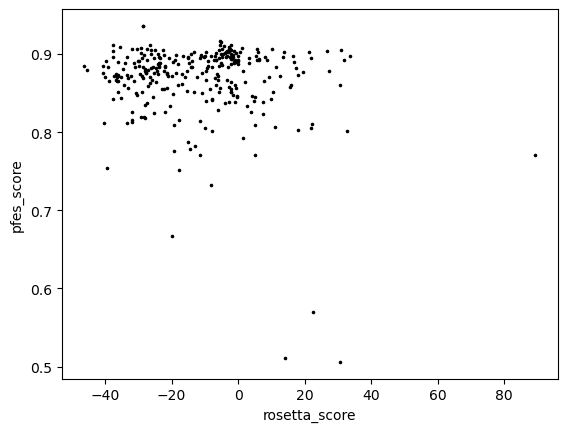

PearsonRResult(statistic=-0.15880814343445343, pvalue=0.0062682875116317725)


In [27]:
df = lineage_dict['pfe50_27']
df = df.dropna()
df = df[df.NA <100]
x = df.NA
y = df.mean_plddt
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c='black', s=10, marker='.')
plt.xlabel("rosetta_score")
plt.ylabel("pfes_score")
plt.show()
print(pearsonr(x, y))


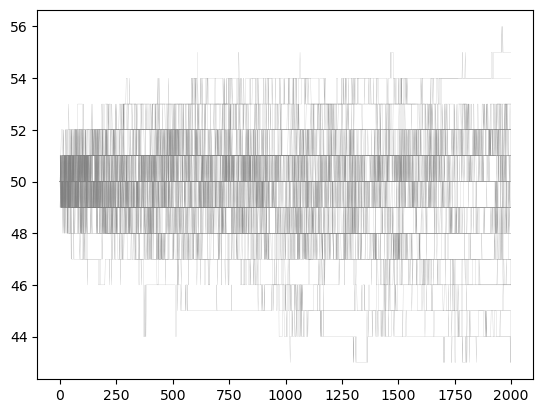

In [28]:
for pfe in bestlog_dict.keys():
    plt.plot(bestlog_dict[pfe].seq_len, '-', c='grey', linewidth=0.1)

# AA composition

In [333]:
alphabet = list('ACDEFGHIKLMNPQRSTVWY')


one2three = {'C': 'CYS', 'D': 'ASP', 'S': 'SER', 'Q': 'GLN', 'K': 'LYS',
             'I': 'ILE', 'P': 'PRO', 'T': 'THR', 'F': 'PHE', 'N': 'ASN', 
             'G': 'GLY', 'H': 'HIS', 'L': 'LEU', 'R': 'ARG', 'W': 'TRP', 
             'A': 'ALA', 'V': 'VAL', 'E': 'GLU', 'Y': 'TYR', 'M': 'MET'}


three2one = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
             'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
             'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
             'ALA': 'A', 'VAL': 'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

one2three ={}

uniprot = {'amino_acid': ['Leu', 'Ala', 'Gly', 'Val', 'Ser', 'Glu', 'Arg', 'Thr', 'Ile', 'Asp', 'Pro', 'Lys', 'Phe', 'Gln', 'Asn', 'Tyr', 'Met', 'His', 'Cys', 'Trp'],
'percent': [9.84, 9.00, 7.26, 6.86, 6.85, 6.25, 5.85, 5.56, 5.52, 5.48, 5.01, 4.95, 3.88, 3.81, 3.80, 2.88, 2.33, 2.23, 1.30, 1.30]}

#https://www.uniprot.org/uniprotkb/statistics#amino-acid-composition
swissprot = {'amino_acid': ['Leu', 'Ala', 'Gly', 'Val', 'Glu', 'Ser', 'Ile', 'Lys', 'Arg', 'Asp', 'Thr', 'Pro', 'Asn', 'Gln', 'Phe', 'Tyr', 'Met', 'His', 'Cys', 'Trp'],
'percent': [9.65, 8.26, 7.07, 6.86, 6.72, 6.65, 5.91, 5.80, 5.53, 5.46, 5.36, 4.75, 4.06, 3.93, 3.87, 2.92, 2.41, 2.28, 1.39, 1.10]}	

color_code_full = {'AA': ['A',  'C',  'D',  'E',  'F',  'G',  'H',  'I',  'K',  'L',  'M',  'N',  'P',  'Q',  'R',  'S',  'T',  'V',  'W',  'Y'], 
                           'color': ['BLUE', 'PINK', 'MAGENTA', 'MAGENTA', 'BLUE', 'ORANGE', 'CYAN', 'BLUE', 'RED', 'BLUE',
                                      'BLUE', 'GREEN', 'GOLD', 'GREEN', 'RED', 'GREEN', 'GREEN', 'BLUE', 'BLUE', 'CYAN'], 
                           'feature': ['Hydrophobic', 'Cysteines', 'Negative_charge', 'Negative_charge', 'Hydrophobic', 
                                       'Glycines', 'Aromatic', 'Hydrophobic', 'Positive_charge', 'Hydrophobic', 'Hydrophobic', 
                                       'Polar', 'Prolines', 'Polar', 'Positive_charge', 'Polar', 'Polar', 'Hydrophobic', 'Hydrophobic', 'Aromatic' ]}

color_code = {AA:color for AA, color in zip(color_code_full['AA'], color_code_full['color'])}


dfUP = pd.DataFrame(uniprot).sort_values('amino_acid')
dfSP = pd.DataFrame(swissprot).sort_values('amino_acid')
resdata = pd.DataFrame({'amino_acid': dfUP.amino_acid, 'UPpercent': dfUP.percent, 'SPpercent': dfSP.percent})
resdata.insert(loc=0, column='AA', value=[three2one[AA] for AA in resdata.amino_acid.str.upper()])
resdata_sorted = resdata.sort_values('AA')


In [ ]:
logdf = all_log
seqstrs = logdf[(logdf.ptm > 0.8) & (logdf.mean_plddt > 0.8)].sequence.str #.drop_duplicates('sequence')
len(seqstrs.len())

In [342]:
AAoccurance = {AA: seqstrs.count(AA).sum() for AA in alphabet} 
n_allAA = sum(AAoccurance.values())
pfes_percent = {AA:round((AAoccurance[AA]/n_allAA) * 100, 3) for AA in AAoccurance}

In [343]:
codonrates = {'A' : 4,  'C' : 2,  'D' : 2,  'E' : 2,  
              'F' : 2,  'G' : 4,  'H' : 2,  'I' : 3,  
              'K' : 2,  'L' : 6,  'M' : 1,  'N' : 2,  
              'P' : 4,  'Q' : 2,  'R' : 6,  'S' : 6,  
              'T' : 4,  'V' : 4,  'W' : 1,  'Y' : 2
              }

resdata_sorted['pfes_percent'] = pfes_percent.values()
resdata_sorted.reset_index(inplace = True, drop=True )
resdata_sorted['codonr'] = codonrates.values()

PearsonRResult(statistic=0.439966174428057, pvalue=0.05223016996483275)


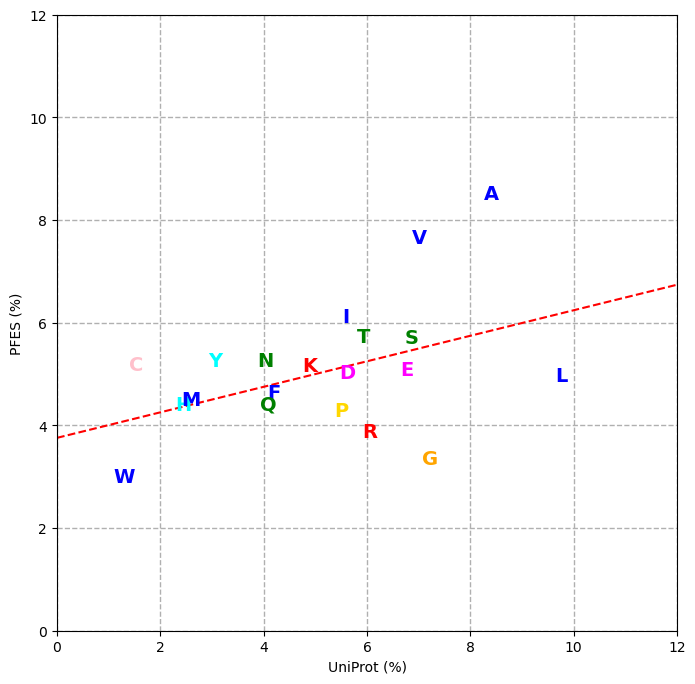

In [344]:
x = resdata_sorted.SPpercent
y = resdata_sorted.pfes_percent



fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
ax.scatter(x, y, s=0)
ax.set_xlim(0,12)
ax.set_ylim(0,12)
ax.set_xlabel('UniProt (%)')
ax.set_ylabel('PFES (%)')

for i, res in enumerate(resdata_sorted.AA):
    ax.annotate(res, (x[i], y[i]), c = color_code[res], fontsize=14, weight='bold')

m, b = np.polyfit(x, y, 1)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1], 100)
plt.plot(X_plot, m*X_plot + b, '--', color='red')
plt.grid(True, which="both",linestyle='--', linewidth=1)
print(pearsonr(list(resdata_sorted.SPpercent), list(resdata_sorted.pfes_percent)))


# Substitution matrix 

In [55]:
matrix_log = all_log
mutations_list = list(matrix_log[(matrix_log.mutation.str.contains('\.')) & (matrix_log.mean_plddt > 0.85) & (matrix_log.ptm > 0.75)].mutation) #.drop_duplicates('sequence')
subst_list = [(m[0],m[-1]) for m in mutations_list]
len(subst_list)

1602144

In [51]:

matrix=np.empty((20,20))
for a, i in zip(alphabet,range(20)):
    for b, j in zip(alphabet,range(20)):
        matrix[i][j] = subst_list.count((a,b))

for i in range(20): matrix[i][i] = 0.1 

matrix = matrix/matrix.max()


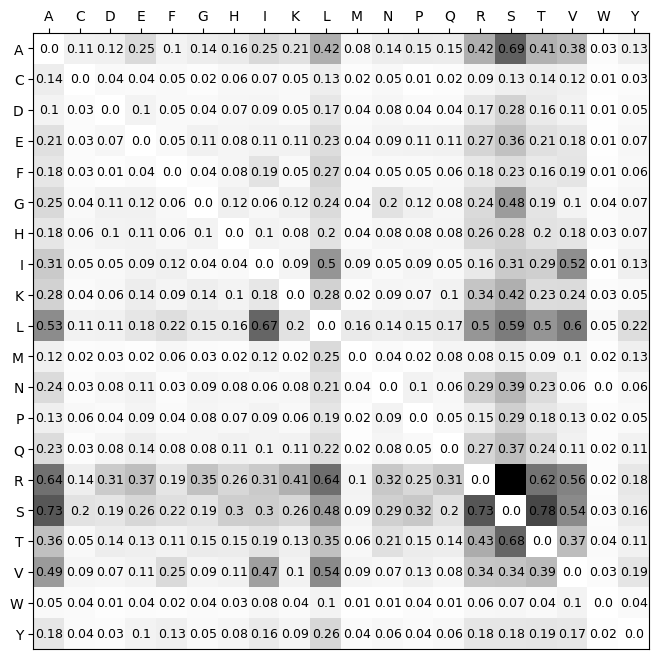

In [52]:
fig, ax = plt.subplots(figsize=(8,8), dpi=100)
ax.imshow((matrix), cmap='Greys')
ax.xaxis.tick_top()
ticks = alphabet
plt.setp(ax, xticks=range(20), xticklabels=ticks, yticks=range(20), yticklabels=ticks)

for (j,i),label in np.ndenumerate(matrix):
    ax.text(i,j,round(label,2),ha='center',va='center', size=9)


In [ ]:
matrix2 = matrix.copy()
matrix2[matrix2 == 0] = matrix.max()

# 

# Fold nucleation time

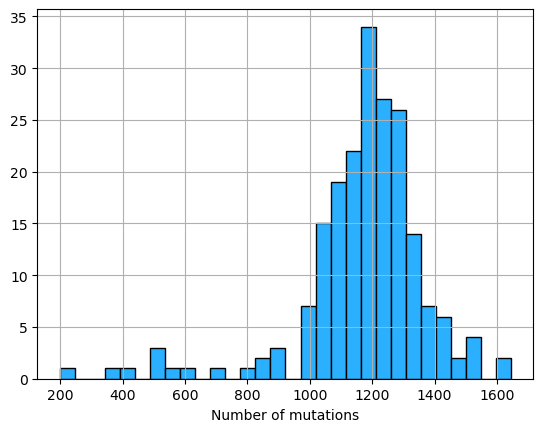

In [373]:
lineage_len = {}
for pfe in lineage_dict.keys():
    lineage_len[pfe] = len(lineage_dict[pfe])
plt.style.use('default')

# histogram on linear scale
#plt.subplot(211)
hist, bins, _ = plt.hist(lineage_len.values(), bins=30,  facecolor = '#2ab0ff', edgecolor='black', linewidth=1)
plt.xlabel('Number of mutations')
plt.grid(True, which="both")



In [347]:
lineage_time = {}
for pfe in lineage_dict.keys():
    df=lineage_dict[pfe]
    dfmusk =  (df.ptm > 0.75) & (df.mean_plddt > 0.85)
    if dfmusk.any():
        lineage_time[pfe] = (df[dfmusk].index[0])
print(len(lineage_time))


181


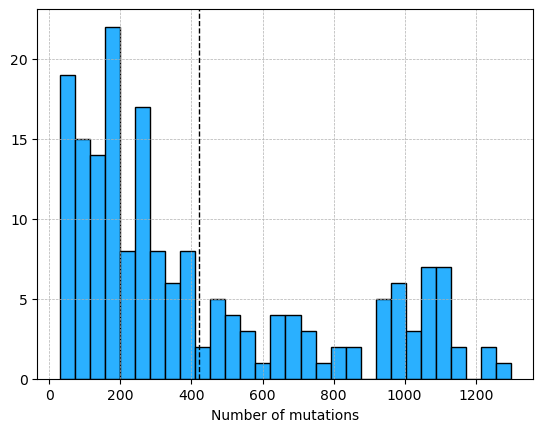

In [372]:
plt.style.use('default')

# histogram on linear scale
#plt.subplot(211)
hist, bins, _ = plt.hist(lineage_time.values(), bins=30,  facecolor = '#2ab0ff', edgecolor='black', linewidth=1)
plt.xlabel('Number of mutations')
plt.axvline(np.array([*lineage_time.values()]).mean(), color='k', linestyle='dashed', linewidth=1)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)



In [349]:
log_time = []
for pfe in bestlog_dict.keys():
    df=bestlog_dict[pfe]
    dfmusk = (df.mean_plddt > 0.85) & (df.ptm > 0.75)
    if dfmusk.any():
        log_time.append(df[dfmusk].index[0])
print(len(log_time))

190


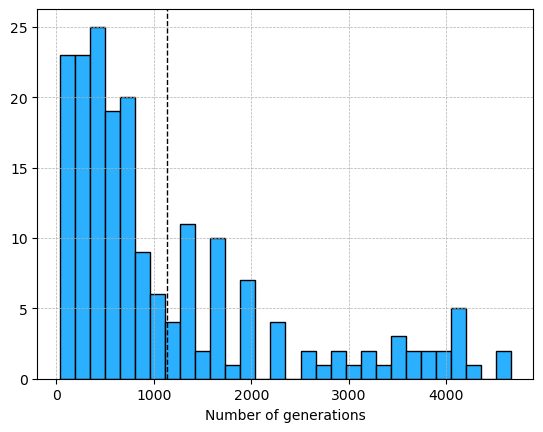

In [359]:
plt.style.use('default')

# histogram on linear scale
#plt.subplot(211)
hist, bins, _ = plt.hist(log_time, bins=30,  facecolor = '#2ab0ff', edgecolor='black', linewidth=1,)
plt.xlabel('Number of generations')
plt.axvline(np.array(log_time).mean(), color='k', linestyle='dashed', linewidth=1)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)




In [390]:
lineage_tails = {}
for pfe in lineage_dict.keys():
    #hist, bins, _ = plt.hist(
        t  = lineage_dict[pfe].iloc[-1].ss
        lineage_tails[pfe] = t
lineage_tails  = np.array(lineage_tails) 

In [395]:
all_ss = ''.join([*finals.ss])
n_h = all_ss.count('H')
n_e = all_ss.count('E')
n_c = all_ss.count('C')


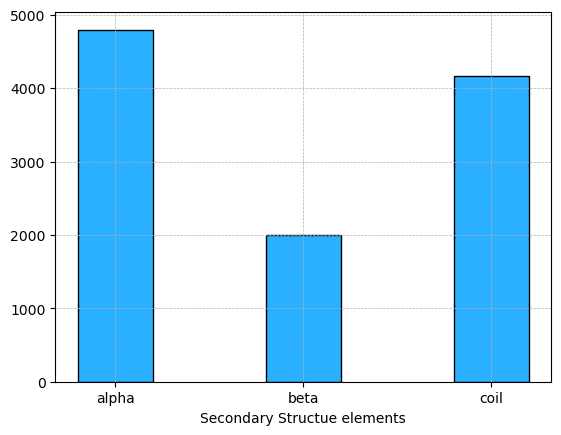

In [397]:
plt.style.use('default')
plt.bar(['alpha','beta', 'coil'],[n_h, n_e, n_c] , width = 0.4,facecolor = '#2ab0ff', edgecolor='black', linewidth=1,)
plt.xlabel('Secondary Structue elements')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)



In [399]:
mixed = 0
alpha = 0
beta = 0
for ss in [*finals.ss]:
    if ('H' in ss) & ('E' in ss):
        mixed +=1
    if ('H' in ss) & ('E' not in ss):
        alpha +=1
    if ('H' not in  ss) & ('E' in ss):
        beta +=1


In [400]:
lineage_tails

array({'run1': 'CCHHHHHHHHHHHHCCCCHHHHHHHHHCCCHHHHHHHHGGGGGC', 'run10': 'CCCCHHHHHHHHHCCCCCHHHHHHHHHHHHHCCCCCCHHHHHHHHHHHCCCHHHHHHHHHHHHHCCCC', 'run100': 'CCCCEEECCCCCCEEEECCCCCCCCCCCCCCEEEECCC', 'run101': 'CCHHHHHHHHHHHHHHHHHCCCCCCCCCCCCHHHHHHHHHIIICCCCCCHHHHHHHHHHCCCCCCC', 'run102': 'CCEEEEECCCCCEEEEECCCCCCCCCEEEECCEEECC', 'run103': 'CCHHHHHHHHHHCCCCCCCCCHHHHHHHHHHGGGCCCCHHHHHHHHHCCCCGGGGGCCCHHHHHHHHHHCC', 'run104': 'CCCHHHHHHHHHHHCCCCCCCHHHHHHHHGGGGGCCHHHHHHHHHHHCCCCHHHHHHHHHHC', 'run105': 'CCCCEEEEECCEEEEEECCCEEEEEECCCCCCCEEECCCCCCCEEEECCCCEEEEEECCEEEPPPPCCCCCCCPPPPCC', 'run106': 'CCCCHHHHHHHHGGGGCCCCHHHHHHCCCCCHHHHHHHHHCCCC', 'run107': 'CCCCEEECCCPPPEEEECCCCCEEEEECCCCEEECCEEECCHHHHHHHHHHHCC', 'run108': 'CEEEEEEECCCCCCEEEEEEEECCCCCEEEEEECCCCEEEEEEEECCCCCEEEEEECCCCCEEEEECCCCCCCEEEEEECCCCCEEEEEECCCCCEEEEEECCCCCEEEEC', 'run109': 'CCCHHHHHHHHHHHHHCCCHHHHHHHHHHHHCCC', 'run11': 'CEEEEEECCCCCCCEEEEEECCEEEEEEECCCCCCCEEEEECCCCCCCEEEEECCCCCCCEEEEEECCCCCEEEEECCCCCCCEEECCCC', 'run110': 'CCCCHH

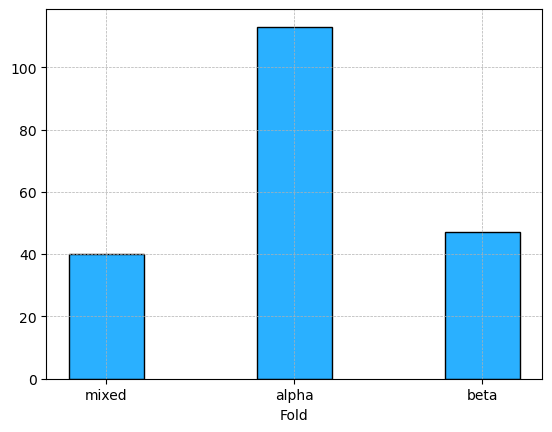

In [401]:
plt.style.use('default')
plt.bar(['mixed','alpha','beta'],[mixed, alpha, beta] , width = 0.4,facecolor = '#2ab0ff', edgecolor='black', linewidth=1,)
plt.xlabel('Fold')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)



In [351]:
df = pd.DataFrame({'names':list(lineage_time.keys()), 'nmut':list(lineage_time.values())})
df.sort_values('nmut').tail(20)

,names,nmut
80,run179,1023
140,run59,1049
73,run171,1059
161,run80,1060
14,run114,1064
124,run43,1071
117,run37,1076
53,run151,1082
151,run71,1093
149,run69,1097


131.7581949765858

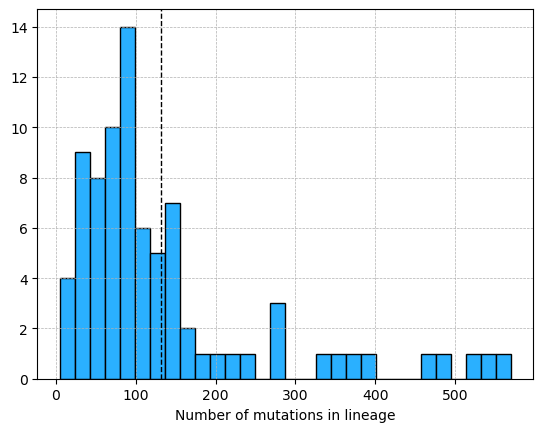

In [352]:
a= np.linspace(5, 570, 30)
b = np.array([4,9,8,10,14,6,5,7,2,1,1,1,1,0,3,0,0,1,1,1,1,0,0,0,1,1,0,1,1,1])

plt.hist(a, bins=30,  weights=b, facecolor = '#2ab0ff', edgecolor='black', linewidth=1)
plt.xlabel('Number of mutations in lineage')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.axvline((a * b).sum()/b.sum(), color='k', linestyle='dashed', linewidth=1)
(a * b).sum()/b.sum()





282.1610501567398

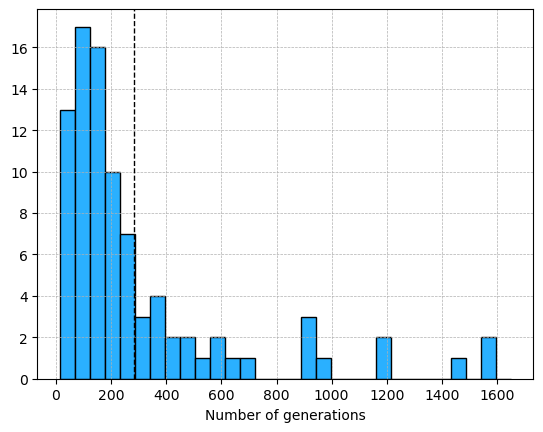

In [355]:
a = np.linspace(15, 1650, 30)
b = np.array([13, 17, 16, 10, 7, 3, 4, 2, 2, 1, 2, 1, 1, 0, 0, 0, 3, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0])


plt.hist(a, bins=30,  weights=b, facecolor = '#2ab0ff', edgecolor='black', linewidth=1)
plt.xlabel('Number of generations')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.axvline((a * b).sum()/b.sum(), color='k', linestyle='dashed', linewidth=1)

(a * b).sum()/b.sum()